# The Validation partition of the dataset

This notebook presents some of the common practices in training a classification model, namely:

- use of a validation set
- early stopping
- learning rate scheduler

# Auxiliary Function

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import sys
sys.path.insert(1, './util')
import vcpi_util

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 32
EPOCHS = 20

cuda:0


In [35]:
PATH_TRAINING_SET = "./gtsrb_datasets/train_full"
PATH_TEST_SET = "./gtsrb_datasets/test"

In [36]:
trasnform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

In [37]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


In [38]:
import torch.utils


train_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform=trasnform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform=trasnform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


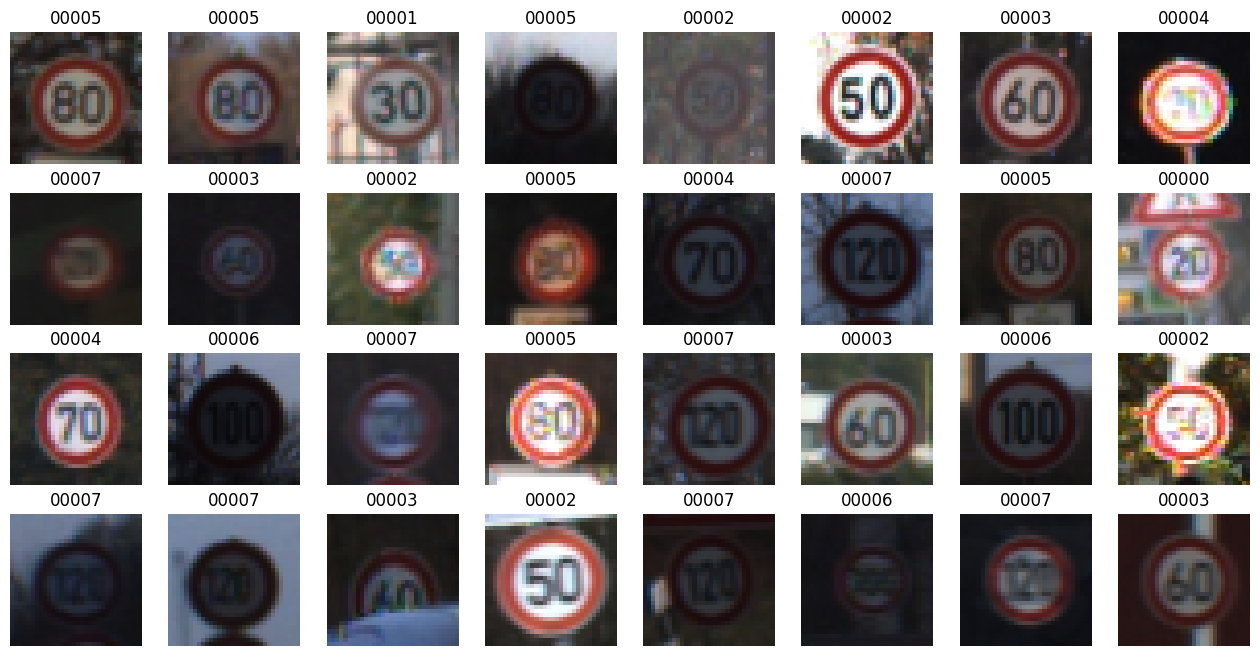

<Figure size 640x480 with 0 Axes>

In [39]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4, 8, images, targets,train_set.classes)

In [40]:
class Conv_II(torch.nn.Module):
    def __init__(self, num_classes):

        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2) 
        
        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()
        
        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()
        
        self.maxpool2 = torch.nn.MaxPool2d(2)


        self.fc1 = torch.nn.Linear(1200, num_classes)

    def forward(self,x):
        # input = (bs, 1, 32, 32)

        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.maxpool1(x) # -> bs(32 canais, 14 x 14)

        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.maxpool2(x) # -> bs(32 canais, 5 x 5)
        
        x = torch.flatten(x, 1) # Gera um array bs 48 * 4 * 4
        x = self.fc1(x) # -> bs, 768 para bs, 10


        return (x)
    
model_conv_II = Conv_II(len(train_set.classes))
model_conv_II.to(device)
print(model_conv_II)

torchinfo.summary(model_conv_II,input_size = (BATCH_SIZE, 3, 32, 32))

Conv_II(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=8, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv_II                                  [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

In [41]:
def train(model, data_loader, epochs, loss_fn, optimizer):
    
    model.train()

    history = {}
    history["accuracy"] = []
    history["loss"] = []

    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0

        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # PASSA PARA GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            # ESTATISTICAS
            _,pred = torch.max(outputs, 1)
            correct += (pred == targets).sum()

            running_loss += loss


        t_correct = 0
        for i,t in test_loader:
            i = i.to(device)
            t = t.to(device)
            o = model(i)

            _, p = torch.max(o, 1)
            t_correct += (t == p).sum()




        accuracy = 100 * correct/len(train_set)
        stop_time = time.time()

        print(f'Epoch: {epoch:03d}; Acc = {accuracy:0.4f}; ACC_T = {100*t_correct/len(test_set)}; Time = {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history["loss"].append(running_loss.cpu().detach().numpy())
    return history

In [42]:
optimizer_I = torch.optim.Adam(model_conv_II.parameters())
loss_fn = torch.nn.CrossEntropyLoss()


In [ ]:

history_I = train(model_conv_II, train_loader, EPOCHS, loss_fn, optimizer_I)

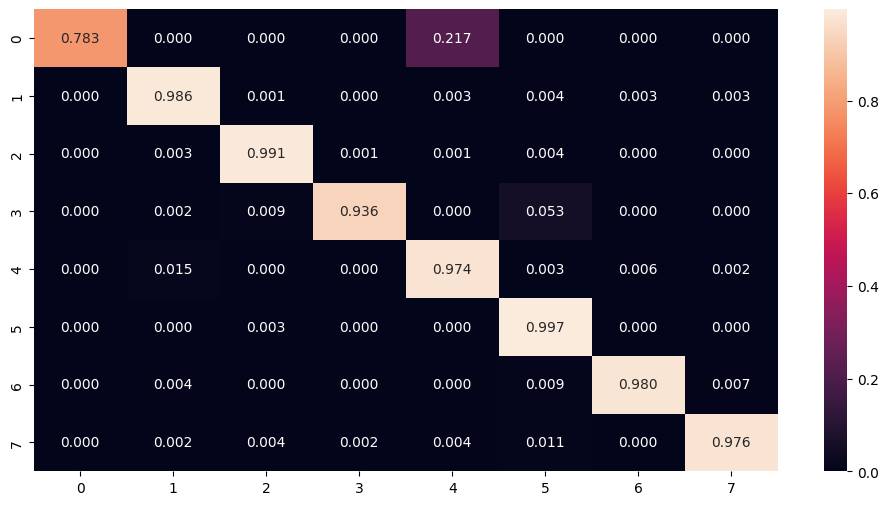

In [ ]:
preds = []
ground_truth = []

for images, targets in test_loader:

    logits = model_conv_II(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux)
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, 8)

Counter({2: 1770, 1: 1740, 4: 1590, 5: 1500, 6: 1170, 3: 1140, 7: 1110, 0: 180})


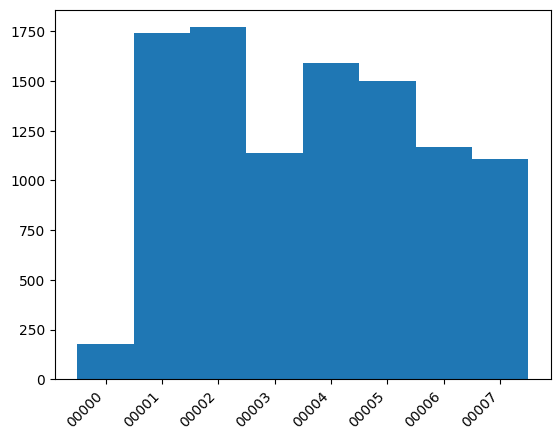

In [ ]:
target_list = []

for images, targets in train_loader:
    target_list.extend(targets)
vcpi_util.show_histogram(target_list,train_set.classes)

## CONTINUAÇÃO NA AULA 9
12/04/2024

In [43]:
train_sub, val_sub = torch.utils.data.random_split(train_set, [10200, 2580])

In [45]:
import torch.utils.data
import torch.utils.data.dataloader


train_sub_loader = torch.utils.data.DataLoader(train_sub,batch_size=BATCH_SIZE,shuffle=True)
val_sub_loader = torch.utils.data.DataLoader(val_sub, batch_size=BATCH_SIZE)

In [60]:
def train(model, data_loader, val_sub_loader, epochs, loss_fn, optimizer):
    
    model.train()

    history = {}
    history["accuracy"] = []
    history["val_acc"] = []
    history["loss"] = []

    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0

        for i, (inputs, targets) in enumerate(data_loader, 0):
            
            # PASSA PARA GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            # ESTATISTICAS
            _,pred = torch.max(outputs, 1)
            correct += (pred == targets).sum()

            running_loss += loss


        t_correct = 0
        for i,t in val_sub_loader:
            i = i.to(device)
            t = t.to(device)
            o = model(i)

            _, p = torch.max(o, 1)
            t_correct += (t == p).sum()




        accuracy = 100 * correct/len(train_sub)
        val_accuracy = 100 * t_correct/len(val_sub)
        stop_time = time.time()

        print(f'Epoch: {epoch:03d}; Acc = {accuracy:0.4f}; Val_acc {val_accuracy:0.4f}; Time = {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history["val_acc"].append(val_accuracy.cpu().numpy())
        history["loss"].append(running_loss.cpu().detach().numpy())
    return history

In [51]:
model_Conv_III = Conv_II(len(train_set.classes))
model_Conv_III.to(device)

optimizer_II = torch.optim.Adam(model_Conv_III.parameters())

In [52]:
history_II = train(model_Conv_III, train_sub_loader,val_sub_loader,EPOCHS,loss_fn,optimizer_II)


Epoch: 000; Acc = 83.0098; ACC_T = 60.887290954589844; Time = 69.1372
Epoch: 001; Acc = 98.9020; ACC_T = 60.887290954589844; Time = 8.4230
Epoch: 002; Acc = 99.4804; ACC_T = 61.29496383666992; Time = 8.1812
Epoch: 003; Acc = 99.8824; ACC_T = 61.51079177856445; Time = 8.0705
Epoch: 004; Acc = 99.9608; ACC_T = 61.67865753173828; Time = 8.1291
Epoch: 005; Acc = 99.9804; ACC_T = 61.70263671875; Time = 8.1237
Epoch: 006; Acc = 100.0000; ACC_T = 61.70263671875; Time = 8.1200
Epoch: 007; Acc = 100.0000; ACC_T = 61.70263671875; Time = 8.1196
Epoch: 008; Acc = 100.0000; ACC_T = 61.726619720458984; Time = 8.2973
Epoch: 009; Acc = 98.8824; ACC_T = 60.52758026123047; Time = 8.2059
Epoch: 010; Acc = 99.1863; ACC_T = 61.53477096557617; Time = 8.2442
Epoch: 011; Acc = 99.9706; ACC_T = 61.67865753173828; Time = 8.0137
Epoch: 012; Acc = 100.0000; ACC_T = 61.7505989074707; Time = 8.4739
Epoch: 013; Acc = 100.0000; ACC_T = 61.70263671875; Time = 8.2153
Epoch: 014; Acc = 100.0000; ACC_T = 61.70263671875; 

In [54]:
evaluate(model_Conv_III,test_loader)

0.986810564994812

In [55]:
PATH_VAL_SET = "./gtsrb_datasets/val"
PATH_TRAIN_PARTIAL_SET = "./gtsrb_datasets/train"

train_partial = torchvision.datasets.ImageFolder(root=PATH_TRAIN_PARTIAL_SET, transform=trasnform)
train_partial_loader = torch.utils.data.DataLoader(train_partial, batch_size=BATCH_SIZE, shuffle=True)

val_set = torchvision.datasets.ImageFolder(root=PATH_VAL_SET, transform=trasnform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)

In [61]:
model_Conv_IIII = Conv_II(len(train_set.classes))

model_Conv_IIII.to(device)

optimizer_III = torch.optim.Adam(model_Conv_IIII.parameters())
history_III = train(model_Conv_IIII, train_partial_loader,val_loader,EPOCHS,loss_fn,optimizer_III)

Epoch: 000; Acc = 82.5980; Val_acc 93.5271; Time = 8.4218
Epoch: 001; Acc = 99.1863; Val_acc 95.8915; Time = 8.0336
Epoch: 002; Acc = 99.7353; Val_acc 95.5814; Time = 8.1661
Epoch: 003; Acc = 99.8529; Val_acc 95.6977; Time = 9.2459
Epoch: 004; Acc = 99.9804; Val_acc 97.3643; Time = 9.0020
Epoch: 005; Acc = 99.9902; Val_acc 97.9845; Time = 8.3261
Epoch: 006; Acc = 100.0000; Val_acc 98.3333; Time = 8.3339
Epoch: 007; Acc = 100.0000; Val_acc 98.3721; Time = 8.8483
Epoch: 008; Acc = 100.0000; Val_acc 98.0620; Time = 8.1320
Epoch: 009; Acc = 100.0000; Val_acc 98.2946; Time = 8.1349
Epoch: 010; Acc = 100.0000; Val_acc 98.3333; Time = 8.0715
Epoch: 011; Acc = 100.0000; Val_acc 98.4884; Time = 8.1788
Epoch: 012; Acc = 100.0000; Val_acc 98.4109; Time = 8.0335
Epoch: 013; Acc = 100.0000; Val_acc 98.3721; Time = 8.1005
Epoch: 014; Acc = 100.0000; Val_acc 98.3721; Time = 8.0888
Epoch: 015; Acc = 100.0000; Val_acc 98.2558; Time = 8.2211
Epoch: 016; Acc = 100.0000; Val_acc 98.4496; Time = 8.1264
Epo

In [62]:
evaluate(model_Conv_IIII,test_loader)

0.978657066822052

In [70]:
from typing import Any


class Early_Stopping():

    def __init__(self, patience=3, min_delta=0.00001):

        self.patience = patience
        self.min_delta = min_delta

        self.min_val_loss = float("inf")
        self.counter = 0

    def __call__(self, val_loss) -> Any:
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter > self.patience:
                return True

        return False

In [63]:
optimizer_aux = torch.optim.Adam(model_Conv_IIII.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_aux, 10, 0.00001)

lrs = []

for epoch in range(50):

    scheduler.step()
    lrs.append(scheduler.get_last_lr())


c:\Users\paulo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


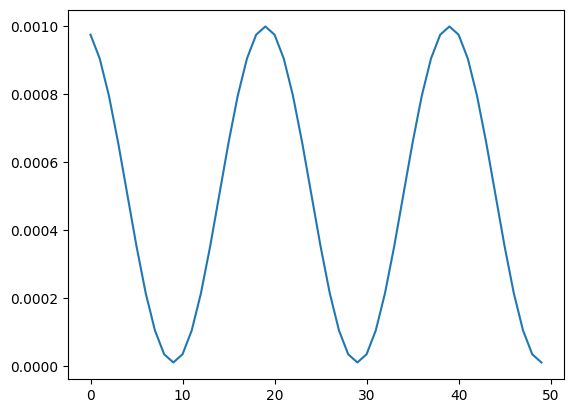

In [64]:
plt.plot(lrs)

In [74]:
def train(
    model,
    data_loader,
    val_sub_loader,
    epochs,
    loss_fn,
    optimizer,
    scheduler,
    early_stopper,
    save_prefix="model",
):

    model.train()

    history = {}
    history["accuracy"] = []
    history["val_acc"] = []
    history["loss"] = []
    history["val_loss"] = []
    best_val_loss = np.inf

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        correct = 0
        running_loss = 0

        for i, (inputs, targets) in enumerate(data_loader, 0):

            # PASSA PARA GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            # ESTATISTICAS
            _, pred = torch.max(outputs, 1)
            correct += (pred == targets).sum()

            running_loss += loss

        model.eval()
        t_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for i, t in val_sub_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)

                _, p = torch.max(o, 1)
                t_correct += (t == p).sum()

                val_loss += loss_fn(o, t)

        old_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]["lr"]
        if old_lr != new_lr:
            print("==> Learning Rate Updated: ", old_lr, " -> ", new_lr)

        accuracy = 100 * correct / len(train_sub)
        val_accuracy = 100 * t_correct / len(val_sub)
        val_loss = val_loss / len(val_sub)
        stop_time = time.time()

        print(
            f"Epoch: {epoch:03d}; Acc = {accuracy:0.4f}; Val_loss {val_loss:0.4f}; Val_acc {val_accuracy:0.4f}; Time = {(stop_time - start_time):0.4f}"
        )
        history["accuracy"].append(accuracy.cpu().numpy())
        history["val_acc"].append(val_accuracy.cpu().numpy())
        history["loss"].append(running_loss.cpu().detach().numpy())
        history["val_loss"].append(val_loss.cpu().detach().numpy())

        if val_loss < best_val_loss:

            best_val_loss = val_loss
            torch.save(
                {
                    "epoch": epoch,
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                f"{save_prefix}.pt"
            )

        if (early_stopper(val_loss)):
            print('Early stopping')
            break

    return history

In [72]:
model_conv_V = Conv_II(len(train_set.classes))

model_conv_V.to(device)

optimizer_IIII = torch.optim.Adam(model_conv_V.parameters())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_IIII, mode='min',factor=0.1,patience=3)

early_stop = Early_Stopping(9)

In [75]:
history_IIII = train(model_conv_V, train_partial_loader,val_loader,EPOCHS,loss_fn,optimizer_IIII,
                     scheduler, early_stop, 'model_5')

Epoch: 000; Acc = 99.3529; Val_loss 0.0057; Val_acc 93.8760; Time = 9.1250
Epoch: 001; Acc = 99.8431; Val_loss 0.0067; Val_acc 92.1705; Time = 8.6986
Epoch: 002; Acc = 99.8824; Val_loss 0.0025; Val_acc 97.4806; Time = 8.3859
Epoch: 003; Acc = 99.9902; Val_loss 0.0027; Val_acc 97.1318; Time = 8.2818
Epoch: 004; Acc = 100.0000; Val_loss 0.0028; Val_acc 96.8605; Time = 8.5201
Epoch: 005; Acc = 100.0000; Val_loss 0.0023; Val_acc 97.7519; Time = 8.3923
Epoch: 006; Acc = 100.0000; Val_loss 0.0023; Val_acc 97.7519; Time = 8.4441
Epoch: 007; Acc = 100.0000; Val_loss 0.0023; Val_acc 97.6357; Time = 49.3823
Epoch: 008; Acc = 100.0000; Val_loss 0.0025; Val_acc 97.5969; Time = 27.0984
Epoch: 009; Acc = 100.0000; Val_loss 0.0023; Val_acc 97.6744; Time = 8.5156
==> Learning Rate Updated:  0.001  ->  0.0001
Epoch: 010; Acc = 100.0000; Val_loss 0.0024; Val_acc 97.7519; Time = 8.2358
Epoch: 011; Acc = 100.0000; Val_loss 0.0023; Val_acc 97.7519; Time = 8.1905
Epoch: 012; Acc = 100.0000; Val_loss 0.0024;

In [76]:
evaluate(model_conv_V,test_loader)

0.9858513474464417

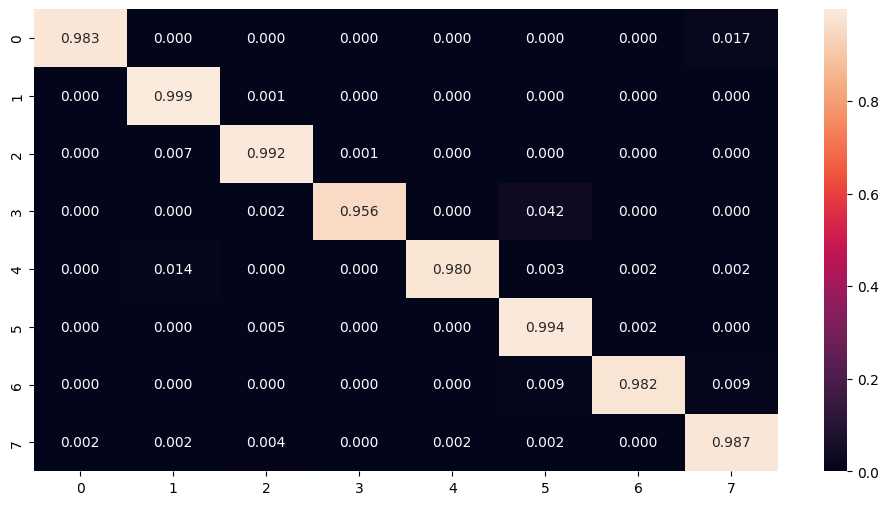

In [77]:
preds = []
ground_truth = []

for images, targets in test_loader:

    logits = model_conv_V(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux)
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, 8)